#### Import Functions

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import pickle

import nltk 


import re
from nltk.tokenize import WordPunctTokenizer

from cleanner import comment_cleaner_updated


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score

#### Load Data

In [2]:
comments = pd.read_csv('./dataset/comments.csv')
stopword = pd.read_csv('./dataset/stopwords.csv')


print('Number of rows total set: {}'.format(comments.shape[0]))
print('Number of stopword: {}'.format(stopword.shape[0]))


Number of rows total set: 3156
Number of stopword: 542


#### Clean Tweet

In [3]:

# cleaned_tweet is used to store the tweets after they have been cleaned
cleaned_tweet = []
for tweet in comments['Tweet']:
  cleaned_tweet.append(comment_cleaner_updated(tweet))


cleaned = pd.DataFrame(cleaned_tweet, columns =['Tweet'])

#### Remove stopword

In [4]:
cleaned['Tweet'] = cleaned['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopword]))
comments['Tweet'] = cleaned['Tweet'] 
comments.dropna(inplace = True)


In [5]:
comments.head()

,Label,Tweet
0,0,haa jaise tum bhi abhi
1,1,banti hai empowered woman feminism pe gyan pel...
2,1,ab usko chhod mjse bat kr tera baap aa gya hai...
3,1,punjab in madarchodon ko khila raha hai nokria...
4,1,agar koi bole ki ja ke chill maar to madarchod...


In [6]:
comments.to_csv('./dataset/CleanedComments.csv')

#### Data classification using pie chart

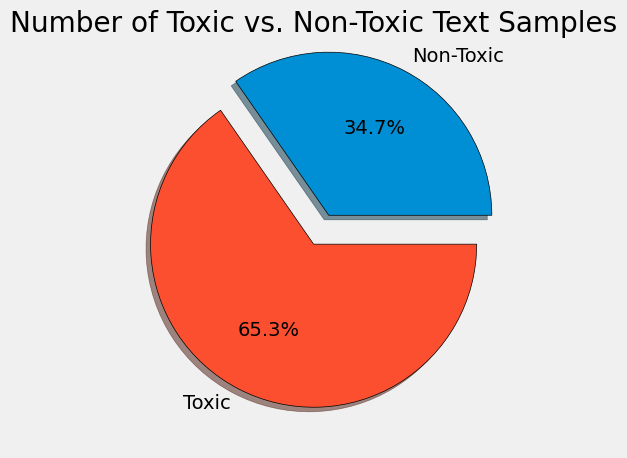

In [7]:
def performDataDistribution(df):
  plt.style.use('fivethirtyeight')

  tot = df.shape[0]
  num_non_toxic = df[df.Label==0].shape[0]
  slices = [num_non_toxic/tot,(tot - num_non_toxic)/tot]
  labeling = ['Non-Toxic','Toxic']
  explode = [0.2,0]
  plt.pie(slices,explode=explode,shadow=True,autopct='%1.1f%%',labels=labeling,wedgeprops={'edgecolor':'black'})
  plt.title('Number of Toxic vs. Non-Toxic Text Samples')
  plt.tight_layout()
  plt.show()

performDataDistribution(comments)

#### Extract data

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(comments, test_size=0.2)


from sklearn.feature_extraction.text import TfidfVectorizer
text_to_vector = TfidfVectorizer()
# TF-IDF feature matrix
text_to_vector.fit(train['Tweet'])

train_vector = text_to_vector.transform(train['Tweet'])

test_vector = text_to_vector.transform(test['Tweet'])
filename = './pickel/tfidf_vector_vocabulary.pkl'


pickle.dump(text_to_vector.vocabulary_, open(filename, 'wb'))


#### Splitting data into training and validation set

In [9]:
#splitting the tfidf features
training_data,testing_data, label_data,label_test, = train_test_split(train_vector, train['Label'], random_state=42, test_size = 0.33)


print('Number of rows in the total set: {}'.format(comments.shape[0]))
print('Number of rows in the training set: {}'.format(training_data.shape[0]))
print('Number of rows in the test set: {}'.format(testing_data.shape[0]))

Number of rows in the total set: 3156
Number of rows in the training set: 1691
Number of rows in the test set: 833


####  Create the model

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [11]:
# Applying ML models
from time import time


def pipeline(X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    # make a list of models
    learner_list = [LinearSVC(),LogisticRegression(),MultinomialNB(),DecisionTreeClassifier(), 
          AdaBoostClassifier(), BaggingClassifier(), SGDClassifier()]
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []

    for learner in learner_list:
        
        print(learner)
        # Store the learner name:
        results['Algorithm'] = learner.__class__.__name__

        # Fit the learner:
        start = time() # Get start time
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(X_train, y_train)
        end = time() # Get end time

        # making pickle file here for my various classifier

        filename = './pickel/'+ learner.__class__.__name__+".pkl"
        pickle.dump(learner, open(filename, 'wb'))


        # Store the training time
        results['Training Time'] = end - start

        start = time() # Get start time
        predictions_test = learner.predict(X_test)
        predictions_train = learner.predict(X_train)
        end = time() # Get end time

        # Store the prediction time
        results['Prediction Time'] = end - start

        # Compute the Accuracy on Test Set
        results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

        # Compute the Accuracy on Training Set
        results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

        # Compute the F1 Score on Test Set
        results['F1 Score: Test'] = f1_score(y_test, predictions_test)

        # Compute the F1 Score on Training Set
        results['F1 Score: Train'] = f1_score(y_train, predictions_train)

        # Compute the Precision on Test Set
        results['Precision: Test'] = precision_score(y_test, predictions_test)

        # Compute the Precision on Training Set
        results['Precision: Train'] = precision_score(y_train, predictions_train)

        # Compute the Recall on Test Set
        results['Recall: Test'] = recall_score(y_test, predictions_test)

        # Compute the Recall on Training Set
        results['Recall: Train'] = recall_score(y_train, predictions_train)

        # Success
        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')
        
        final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results



In [12]:
final_results=pipeline(training_data,label_data,testing_data,label_test)

LinearSVC()
Training LinearSVC
Training LinearSVC finished in 0.01 sec
----------------------------------------------------
LogisticRegression()
Training LogisticRegression
Training LogisticRegression finished in 0.05 sec
----------------------------------------------------
MultinomialNB()
Training MultinomialNB
Training MultinomialNB finished in 0.00 sec
----------------------------------------------------
DecisionTreeClassifier()
Training DecisionTreeClassifier
Training DecisionTreeClassifier finished in 0.32 sec
----------------------------------------------------
AdaBoostClassifier()
Training AdaBoostClassifier
Training AdaBoostClassifier finished in 2.44 sec
----------------------------------------------------
BaggingClassifier()
Training BaggingClassifier
Training BaggingClassifier finished in 5.41 sec
----------------------------------------------------
SGDClassifier()
Training SGDClassifier
Training SGDClassifier finished in 0.01 sec
--------------------------------------------

In [13]:
def performFinalResults(final_results):
  results = pd.DataFrame(final_results)
  results = results.reindex(columns = ['Algorithm', 'F1 Score: Test', 'F1 Score: Train', 'Accuracy: Test', 'Precision: Test', 'Recall: Test',  'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train',  'Training Time'])

  results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

  return results

results=performFinalResults(final_results)
results.reset_index(drop = True)

,Algorithm,F1 Score: Test,F1 Score: Train,Accuracy: Test,Precision: Test,Recall: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,Training Time
0,LinearSVC,0.890110,0.998216,0.855942,0.893382,0.886861,0.001002,0.997635,0.998216,0.998216,0.006001
1,BaggingClassifier,0.886171,0.991007,0.854742,0.914563,0.859489,0.043875,0.988173,0.999093,0.983051,5.412974
2,AdaBoostClassifier,0.882969,0.916978,0.852341,0.922465,0.846715,0.094437,0.894737,0.960899,0.876896,2.438512
3,SGDClassifier,0.881132,0.998214,0.848739,0.912109,0.852190,0.002040,0.997635,0.999106,0.997324,0.007533
4,DecisionTreeClassifier,0.860294,0.999554,0.817527,0.866667,0.854015,0.001961,0.999409,1.000000,0.999108,0.324970
5,LogisticRegression,0.841584,0.924560,0.769508,0.768072,0.930657,0.001002,0.893554,0.871937,0.983943,0.047990
6,MultinomialNB,0.836570,0.903854,0.757503,0.751453,0.943431,0.001002,0.859846,0.828869,0.993756,0.001957


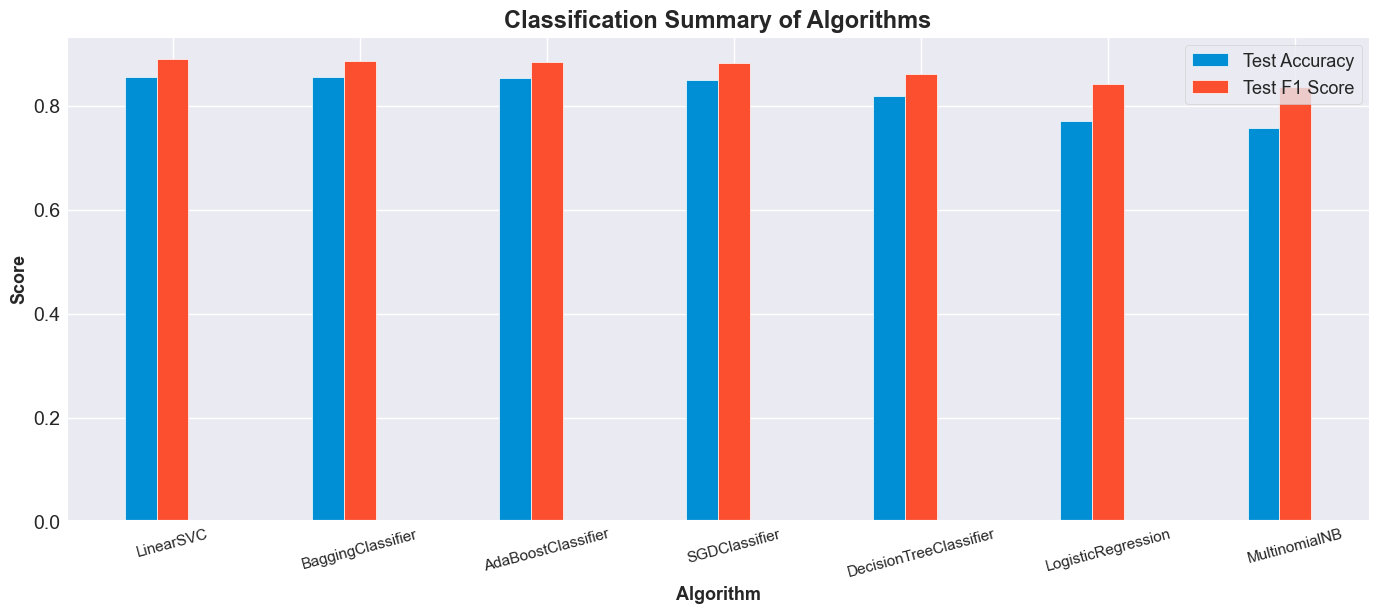

In [14]:
# Classification of Summary of Algorithma 
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (15, 6))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Test F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

In [15]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

Text(0.5, 1.0, 'Training and Prediction time of Algorithms')

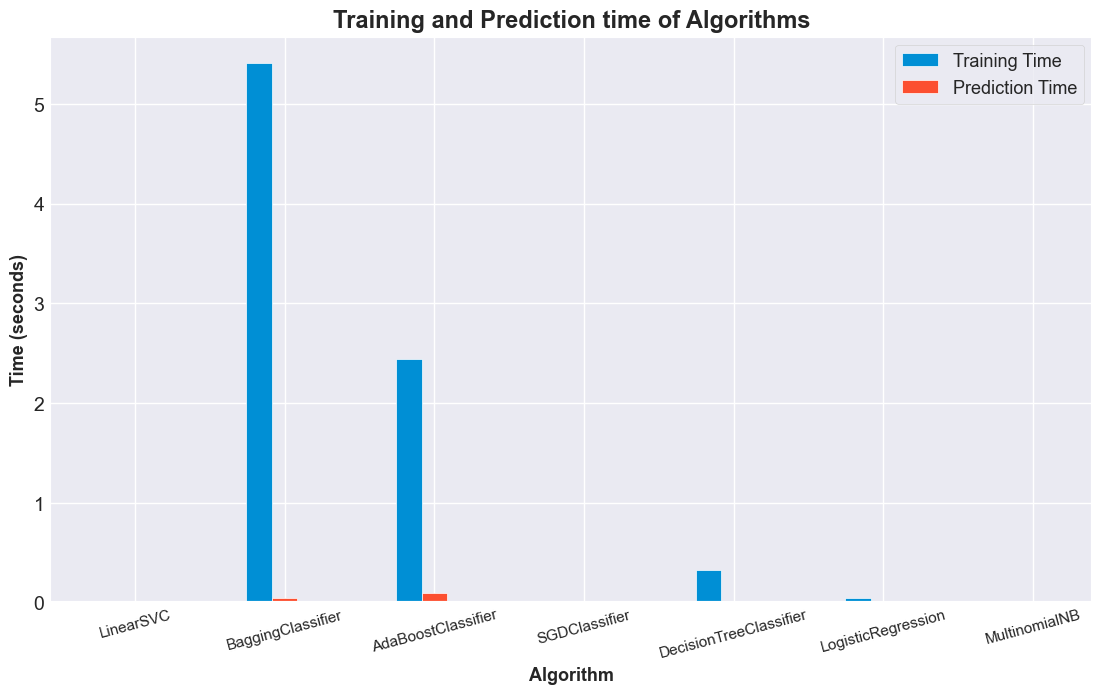

In [16]:
barWidth = 0.17

plt.figure(figsize = (12, 7))
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)


textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
# plt.text(3.2, 12, textstr, fontsize=14,  bbox=props) 

# Create legend & Show graphic
plt.legend(fontsize = 13)

plt.title('Training and Prediction time of Algorithms', fontweight = 'bold', fontsize = 17)

#### User testing

In [17]:
data = ["Bc madarchod South Africa" , 'i like you' , 'Good Pic ' , 'my teri maka ki' , 'hot' , 'Bollywood is dumb']
# data = ['Bc madarchod South Africa']

In [18]:
# use_text_to_vertor= pickle.load(open("./pickel/tfidf_vector_vocabulary.pkl", "rb"))
use_text_to_vertor = TfidfVectorizer( lowercase = True,vocabulary=pickle.load(open("./pickel/tfidf_vector_vocabulary.pkl", "rb")))


data = [comment_cleaner_updated(i) for i in data]
print(data)
data= use_text_to_vertor.fit_transform(data)
print(data.shape)

trained_model=pickle.load(open("./pickel/LinearSVC.pkl", 'rb'))

for i in data:
  if(trained_model.predict(i)==1):
    print('bullying')
  else:
    print('non-bullying')

['bc madarchod south africa', 'like you', 'good pic', 'my teri maka ki', 'hot', 'bollywood is dumb']
(6, 7132)
bullying
bullying
non-bullying
bullying
non-bullying
bullying
